# Diabetes Dataset Prediction RNN

## Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hasibur013/diabetes-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/hasibur013/diabetes-dataset/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/hasibur013/diabetes-dataset/versions/1

diabetes_dataset.csv


## Import libraries

In [25]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Reshape, Bidirectional, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.optimizers import Adam
from tensorflow.keras.saving import load_model

## Load Dataset

In [4]:
diabetes_df = pd.read_csv(path + '/diabetes_dataset.csv')

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data Preparation

In [6]:
labels = diabetes_df['Outcome']
features = diabetes_df.drop(columns=['Outcome'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [8]:
X_train.shape[1]

8

## Model

In [21]:
model = Sequential(name = 'diabetes_model')
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), name = 'input_layer'))
model.add(Reshape((1, 64), name = 'reshape_layer'))  # Reshape to (batch_size, timesteps, features)
model.add(LSTM(64, activation='relu', dropout=0.1, return_sequences=True, name = 'rnn_layer_1'))
model.add(LSTM(32, activation='relu', dropout=0.1, return_sequences=True, name = 'rnn_layer_2'))
model.add(LSTM(16, activation='relu', dropout=0.1, name = 'rnn_layer_3'))
model.add(Dense(1, activation='sigmoid', name = 'output_layer'))

model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Model: "diabetes_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (Dense)             │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_layer (Reshape)         │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_1 (LSTM)              │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_2 (LSTM)              │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer_3 (LSTM)              │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,169 (192.07 KB)

 Trainable params: 49,169 (192.07 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_val, y_val), callbacks=[ModelCheckpoint('diabetes_model.keras', monitor='val_accuracy', save_best_only=True, mode='max',)])

Epoch 1/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.6177 - loss: 0.6834 - val_accuracy: 0.6104 - val_loss: 0.6614
Epoch 2/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6434 - loss: 0.6770 - val_accuracy: 0.6753 - val_loss: 0.6541
Epoch 3/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6592 - loss: 0.6628 - val_accuracy: 0.6364 - val_loss: 0.6491
Epoch 4/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6948 - loss: 0.6217 - val_accuracy: 0.6234 - val_loss: 0.6413
Epoch 5/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6620 - loss: 0.6479 - val_accuracy: 0.6494 - val_loss: 0.6395
Epoch 6/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6921 - loss: 0.6262 - val_accuracy: 0.6494 - val_loss: 0.6335
Epoch 7/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6702 - loss: 0.6183 - val_accuracy: 0.6623 - val_loss: 0.6239
Epoch 8/60
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6991 - loss: 0.6243 - val_accuracy: 0.6364 - val_los

## Plot model history

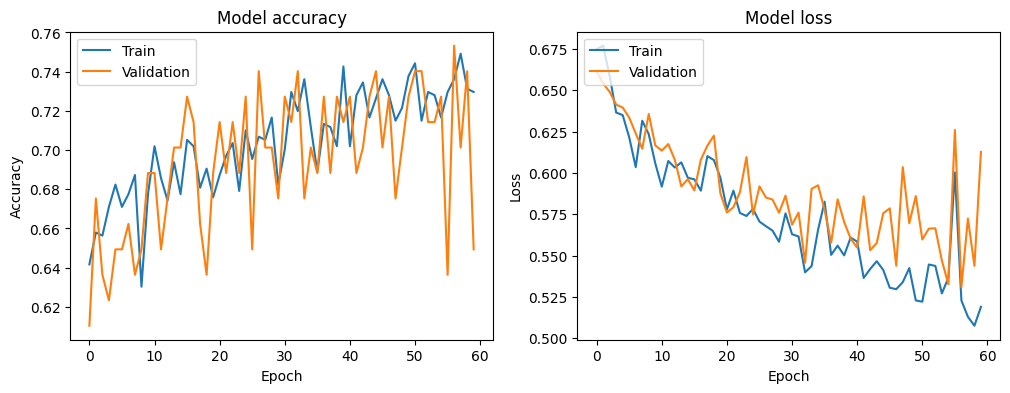

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [27]:
# Train validation data on best model
model = load_model('diabetes_model.keras')

## Good practices: Train with validation data

In [28]:
model_history = model.fit(X_val, y_val, epochs=60, batch_size=32)

Epoch 1/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7425 - loss: 0.5840
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6957 - loss: 0.5542 
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7816 - loss: 0.5455
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6905 - loss: 0.5655
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7764 - loss: 0.5007
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7529 - loss: 0.5145
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7594 - loss: 0.4925
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7906 - loss: 0.5226
Epoch 9/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7321 - loss: 0.5217
Epoch 10/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6827 - loss: 0.5859
Epoch 11/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8284 - loss: 0.4610
Epoch 12/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7282 - loss: 0.5128
Epoch 13/60
3

## Model Evaluation

In [31]:
evaluation = model.evaluate(X_test, y_test)
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7321 - loss: 0.6337 
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step


In [32]:
loss, acc = evaluation
print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.582820475101471
Test accuracy: 0.7532467246055603


## Plotting predictions vs real label

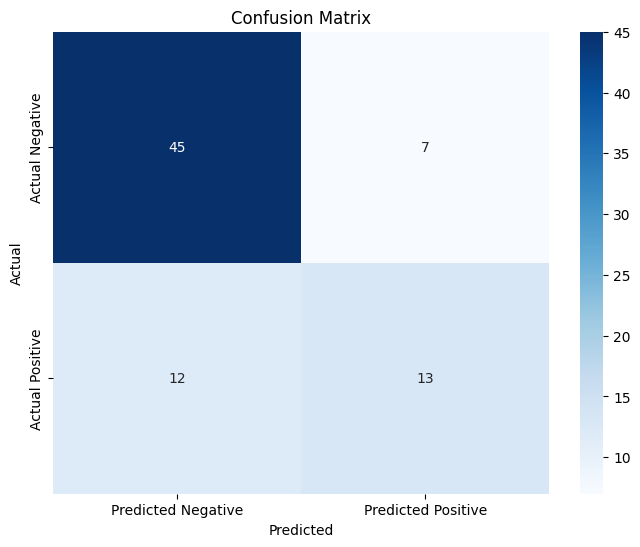

In [33]:
# Convert predictions to binary values (0 or 1) based on a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model failed predictions

In [34]:
for i in range(len(y_test)):
    if y_test.iloc[i] != binary_predictions[i]:
        print(f'Actual: {y_test.iloc[i]}, Predicted: {binary_predictions[i]}')
        print(f'Features: {X_test.iloc[i]}')
        print()

Actual: 1, Predicted: [0]
Features: Pregnancies                   9.000
Glucose                     119.000
BloodPressure                80.000
SkinThickness                35.000
Insulin                       0.000
BMI                          29.000
DiabetesPedigreeFunction      0.263
Age                          29.000
Name: 23, dtype: float64

Actual: 0, Predicted: [1]
Features: Pregnancies                   1.000
Glucose                     151.000
BloodPressure                60.000
SkinThickness                 0.000
Insulin                       0.000
BMI                          26.100
DiabetesPedigreeFunction      0.179
Age                          22.000
Name: 101, dtype: float64

Actual: 1, Predicted: [0]
Features: Pregnancies                  0.000
Glucose                     95.000
BloodPressure               85.000
SkinThickness               25.000
Insulin                     36.000
BMI                         37.400
DiabetesPedigreeFunction     0.247
Age               

## Conclusion

In this notebook, we successfully built and evaluated a Recurrent Neural Network (RNN) model to predict diabetes outcomes using a publicly available dataset. We train the RNN model. The model's performance was evaluated using various metrics, and we visualized the results to gain insights into its accuracy and areas for improvement.